# Data Preprocessing & Preperation

In this notebook, we are aiming to determine what factors, if any, contribute to the length of icu stay in emergency neurological surgereis.  The data was derived from the [inspire dataset](https://physionet.org/content/inspire/1.2/) and aims to be a useful tool perioperative medicine.

Below, follow the comments above each line of code to see what the objectives are in identifying our target variables and cleaning the data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Set variables
OUTCOME_VAR = 'total_icu_stay'
INPUT_VARS = ['age', 'bmi', 'andur', 'asa', 'emop',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium',
              'Index', 'comorbidity_score']

# Load operations data
df = pd.read_csv('data/operations.csv')

# Find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id', 'subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Calculate ICU stay duration
df[OUTCOME_VAR] = df['icuout_time'] - df['icuin_time']

# Filter by ASA score (less than 6)
df = df[df['asa'] < 6]

# Calculate duration of anesthesia
df['andur'] = df['anend_time'] - df['anstart_time']

# Calculate BMI for valid heights
df['bmi'] = np.nan
valid_mask = df['height'] > 10
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs data and merge with operations data
df_lab = pd.read_csv("data/labs.csv")

# Merge labs & operations
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                       df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                       left_on='orin_time', right_on='chart_time', by='subject_id',
                       tolerance=6 * 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value': f'preop_{item_name}'}, inplace=True)

# Load diagnosis data and merge with operations data
df_diagnosis = pd.read_csv('data/diagnosis.csv')
df = pd.merge(df, df_diagnosis[['subject_id', 'icd10_cm']], on='subject_id', how='left')

# Move icd10_pcs to the end of the dataframe
df['icd10_pcs'] = df.pop('icd10_pcs')

# Load neurological comorbidity scores and merge with main dataframe
neuro_comorbidity_df = pd.read_csv('data/Complete_Neurological_Comorbidity_Scores.csv')
df = pd.merge(df, neuro_comorbidity_df[['subject_id', 'comorbidity_score']], on='subject_id', how='inner')

# Drop duplicate patients
df.drop_duplicates(subset='subject_id', inplace=True)

# Load neurological ICD-10 codes and merge to assign the Index score
df_neuro = pd.read_csv("data/Neurological_Surgery_ICD-10_Codes.csv")
df = pd.merge(df, df_neuro[['ICD10 Code', 'Index']], left_on='icd10_pcs', right_on='ICD10 Code', how='left')
df['Index'] = df['Index'].fillna(0)
df.drop(columns=['ICD10 Code'], inplace=True)

# Sort by subject_id and fill all NA values with 0
df.sort_values('subject_id', inplace=True)
df.fillna(0, inplace=True)

# Bucket total ICU stay into categories
bins = [-1, 0, 24*60, 7*24*60, float('inf')]  # Example bins: No ICU, <=1 day, 1-7 days, >7 days
labels = ['No ICU Stay', '<= 1 Day', '1-7 Days', '> 7 Days']
df[OUTCOME_VAR] = pd.cut(df[OUTCOME_VAR], bins=bins, labels=labels)

# Check the dataframe
print(f"Number of rows in the dataframe: {len(df)}")
class_distribution = df[OUTCOME_VAR].value_counts()
print(class_distribution)
df.head()



Number of rows in the dataframe: 5484
total_icu_stay
No ICU Stay    3481
<= 1 Day       1034
1-7 Days        869
> 7 Days        100
Name: count, dtype: int64


,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,asa,emop,department,antype,orin_time,orout_time,opstart_time,opend_time,admission_time,discharge_time,anstart_time,anend_time,cpbon_time,cpboff_time,icuin_time,icuout_time,inhosp_death_time,total_icu_stay,andur,bmi,preop_hb,preop_platelet,preop_aptt,preop_wbc,preop_ptinr,preop_glucose,preop_bun,preop_ast,preop_alt,preop_creatinine,preop_sodium,preop_potassium,icd10_cm,icd10_pcs,comorbidity_score,Index
21,464232551,100010304,212882335,0.0,0,50,F,68.0,160.0,Asian,2.0,1,NS,General,320,490,420.0,480.0,0,21595,400.0,495.0,0.0,0.0,515.0,6660.0,0.0,1-7 Days,95.0,26.562500,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,I60,03VG3,0,13.0
1320,418301274,100030721,276079965,0.0,1440,70,M,64.0,163.0,Asian,1.0,0,NS,General,2085,2235,2100.0,2225.0,0,4315,2085.0,2240.0,0.0,0.0,0.0,0.0,0.0,No ICU Stay,155.0,24.088223,13.7,258.0,32.3,10.22,0.97,96.0,16.0,31.0,30.0,0.71,140.0,4.2,I89,03VG3,0,13.0
4273,475596370,100032651,220635330,0.0,5760,80,M,70.0,160.0,Asian,2.0,0,OS,General,6230,6335,6265.0,6330.0,0,14395,6235.0,6340.0,0.0,0.0,0.0,0.0,0.0,No ICU Stay,105.0,27.343750,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,R52,009T0,0,13.0
3079,417236553,100036262,292040258,0.0,2880,35,F,51.0,160.0,Asian,3.0,0,NS,General,3340,3730,3405.0,3685.0,0,15835,3350.0,3725.0,0.0,0.0,3750.0,6580.0,0.0,1-7 Days,375.0,19.921875,13.2,314.0,38.2,7.05,1.12,84.0,9.0,19.0,17.0,0.68,139.0,4.0,0,031J0,0,1.0
3051,407030722,100036324,224173917,0.0,2880,60,F,51.0,146.0,Asian,2.0,0,NS,General,3340,3820,3425.0,3795.0,0,11515,3360.0,3805.0,0.0,0.0,3820.0,5410.0,0.0,1-7 Days,445.0,23.925690,13.2,258.0,33.0,4.77,0.95,110.0,13.0,15.0,17.0,0.68,145.0,4.0,D33,00B00,0,2.0


In [ ]:
# optionally save the dataset for analysis

df.to_csv('cardiac-subjects-jun20-updated.csv', index=False)

len(df)

#Modeling & Graphs

Utilizing Logisitic Regression and various sampling techniques to address imbalances in the dataset, we are using machine learning to determine the liklihood of post-operative death in cardiac patients and plotting the model results

Original train set class distribution: [ 608  724   70 2436]
Original test set class distribution: [ 261  310   30 1045]
Resampled train set class distribution: [2436 2436 2436 2436]
LR auroc: 0.887
Accuracy: 0.696
Precision: 0.752
Recall: 0.696
F1 Score: 0.717
 
 


<ipython-input-20-35d2162f1188>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_coefficients, y=sorted_features, palette='coolwarm')


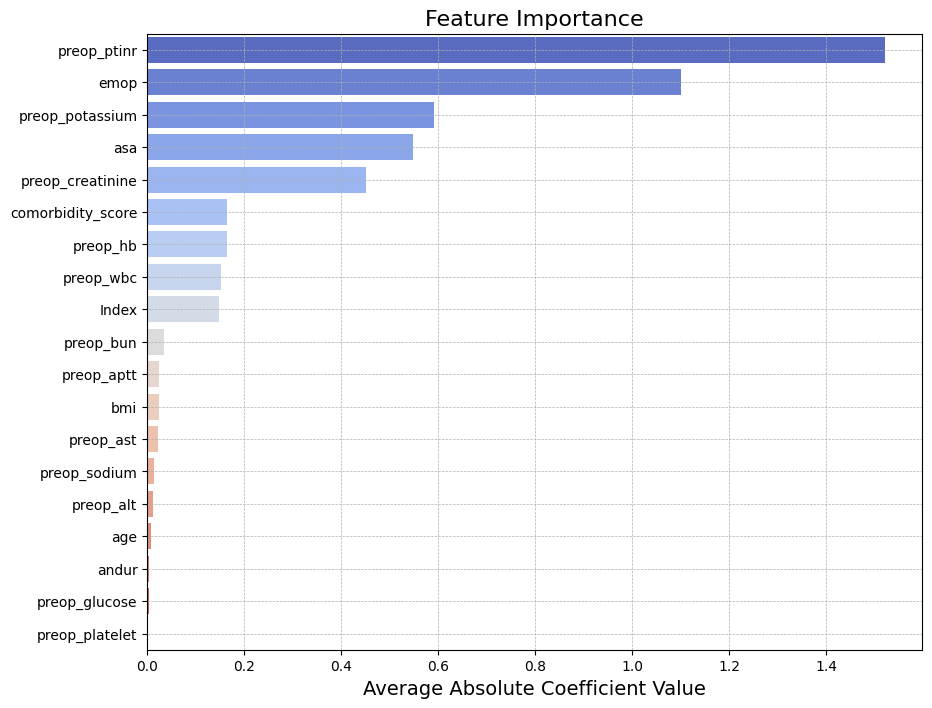

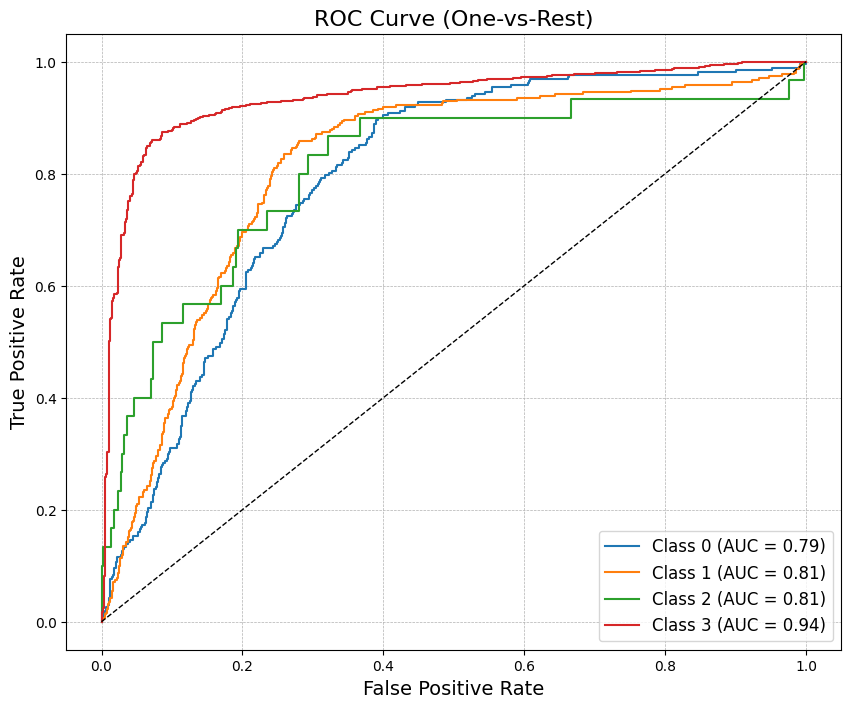

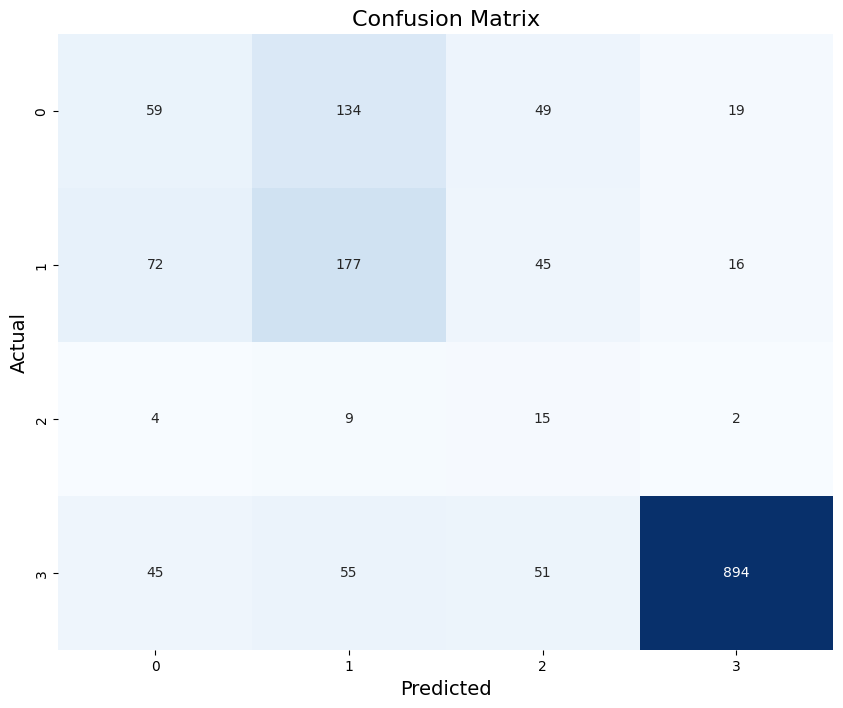

      Metric  Logistic Regression
0   Accuracy             0.695626
1  Precision             0.752219
2     Recall             0.695626
3   F1 Score             0.717105
4      AUROC             0.887442
              op_id    subject_id       hadm_id       case_id        opdate  \
count  5.484000e+03  5.484000e+03  5.484000e+03   5484.000000  5.484000e+03   
mean   4.435566e+08  1.499449e+08  2.505296e+08    794.175966  1.598064e+05   
std    2.876872e+07  2.906324e+07  2.853336e+07   8869.634130  5.787498e+05   
min    4.000213e+08  1.000103e+08  2.000048e+08 -32762.000000  0.000000e+00   
25%    4.184525e+08  1.246405e+08  2.265454e+08      0.000000  1.440000e+03   
50%    4.400985e+08  1.495748e+08  2.510106e+08      0.000000  2.880000e+03   
75%    4.676375e+08  1.750747e+08  2.749999e+08      0.000000  4.320000e+03   
max    4.999116e+08  1.999994e+08  2.999760e+08  32762.000000  5.078880e+06   

               age       weight       height          asa         emop  \
count  548

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Shuffle and split the dataset
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)

# Encode the categorical outcome variable
le = LabelEncoder()
df[OUTCOME_VAR] = le.fit_transform(df[OUTCOME_VAR])

# Stratified split
x_train, x_test, y_train, y_test = train_test_split(
    df[INPUT_VARS], df[OUTCOME_VAR], test_size=0.3, stratify=df[OUTCOME_VAR], random_state=1
)

# Print the original class distribution
print(f'Original train set class distribution: {np.bincount(y_train)}')
print(f'Original test set class distribution: {np.bincount(y_test)}')

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Apply RandomUnderSampler to the SMOTE resampled data
rus = RandomUnderSampler(random_state=1)
x_train_balanced, y_train_balanced = rus.fit_resample(x_train_smote, y_train_smote)

# Print the new class distribution after balancing
print(f'Resampled train set class distribution: {np.bincount(y_train_balanced)}')

# Logistic regression using SimpleImputer
imp = SimpleImputer().fit(x_train_balanced)
x_train_imputed = imp.transform(x_train_balanced)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression
model = LogisticRegression(multi_class='ovr', max_iter=5000).fit(x_train_imputed, y_train_balanced)
y_pred_proba = model.predict_proba(x_test_imputed)
y_pred = model.predict(x_test_imputed)

# Compute metrics
auroc_lr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('LR auroc: {:.3f}'.format(auroc_lr))
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(" \n ")

# Feature importance
feature_names = x_train.columns
coefficients = model.coef_

# Create a list of (feature_name, average_absolute_coefficient) tuples and sort them
features_coefficients = sorted(zip(feature_names, np.mean(np.abs(coefficients), axis=0)), key=lambda x: x[1], reverse=True)
sorted_features, sorted_coefficients = zip(*features_coefficients)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_coefficients, y=sorted_features, palette='coolwarm')
plt.xlabel('Average Absolute Coefficient Value', fontsize=14)
plt.title('Feature Importance', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(model.classes_)):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve (One-vs-Rest)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Tables

# Model Performance Metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC'],
    'Logistic Regression': [accuracy, precision, recall, f1, auroc_lr]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Descriptive Statistics of the Dataset
desc_stats = df.describe()
print(desc_stats)

# Logistic Regression Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Absolute Coefficient': np.mean(np.abs(coefficients), axis=0)
}).sort_values(by='Average Absolute Coefficient', ascending=False)
print(coef_df)

# Confusion Matrix (numerical representation)
cm_df = pd.DataFrame(cm, index=[f'Actual {i}' for i in range(len(model.classes_))],
                     columns=[f'Predicted {i}' for i in range(len(model.classes_))])
print(cm_df)



#Saving The Trained Model for Further Use!

full repository located [here](https://github.com/hofmannj0n/biomedical-research)

In [ ]:
import pickle

with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('imputer.pkl', 'wb') as imputer_file:
    pickle.dump(imp, imputer_file)